In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from statsmodels.tsa.api import VAR
from tqdm import tqdm
import time
import joblib
from collections import defaultdict

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/2d_data_cleaned.parquet")
val_set_original = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/val_set_2D.parquet")
test_set_original = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/test_set_2D.parquet")
cluster_df = pd.read_csv("/content/drive/MyDrive/LSE Capstone G Drive/Results/K-means + VAR/cluster_df.csv")

# Convert date and set index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# Parameters
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

data

,lat_5km,lon_5km,KD490,ZSD,RRS490,RRS443,CHL,MICRO,BBP,CDM
date,,,,,,,,,,
2025-01-26,49.15,-10.75,0.042622,21.520136,0.006361,0.006838,0.197671,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.70,0.043422,21.033817,0.007095,0.007484,0.206785,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.65,0.043873,20.774261,0.005769,0.006020,0.212015,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.60,0.043365,21.072351,0.003745,0.004274,0.206158,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.55,0.044909,20.184818,0.003184,0.004002,0.224094,0.285306,0.003873,0.016502
...,...,...,...,...,...,...,...,...,...,...
2024-11-17,52.25,-4.50,0.135265,5.545503,0.005816,0.006983,1.893622,0.266766,0.003325,0.015229
2024-11-17,52.25,-4.45,0.135620,5.536804,0.005816,0.006983,1.903060,0.266766,0.003325,0.015229
2024-11-17,52.25,-4.40,0.130535,5.786188,0.005816,0.006983,1.782744,0.266766,0.003325,0.015229


# k-Means + VAR with first differencing

## Conduct first differencing on variables grouped by grid point to maintain the spatial structure

In [ ]:
# 1. First difference per grid point function (same as before)
def first_difference_per_grid(df):
    dfs = []

    for (lat, lon), group in df.groupby(['lat_5km', 'lon_5km']):
        group = group.sort_values('date').copy()
        # Keep lat_5km, lon_5km, and date columns
        vars_to_diff = group.columns.difference(['lat_5km', 'lon_5km', 'date'])
        group[vars_to_diff] = group[vars_to_diff].diff()
        group = group.iloc[1:]  # drop first NaN row

        dfs.append(group)

    diff_df = pd.concat(dfs, ignore_index=False)

    # Ensure 'date' is a column (not index)
    if 'date' not in diff_df.columns:
        if 'date' in diff_df.index.names:
            diff_df = diff_df.reset_index(level='date')
        else:
            diff_df = diff_df.reset_index()

    print(diff_df.reset_index(drop=True))

    return diff_df.reset_index(drop=True)

## Create the adjusted train, validation, test sets

In [ ]:
# 2. Adjust date ranges to account for lost first observation
adjusted_train_dates = [('2022-01-28', '2022-11-20'), ('2023-01-28', '2023-11-17')]
val_dates = ('2024-01-26', '2024-07-31')
test_dates = [('2024-08-01', '2024-11-17'), ('2025-01-26', '2025-07-21')]

def filter_by_date_ranges(df, date_ranges):
    masks = [(df['date'] >= start) & (df['date'] <= end) for start, end in date_ranges]
    combined_mask = masks[0]
    for mask in masks[1:]:
        combined_mask = combined_mask | mask
    return df[combined_mask]

# 3. Function to prepare datasets from original full df
def prepare_diff_datasets(df):
    print("Differencing per grid point...")
    df_diff = first_difference_per_grid(df)
    print(f"Differenced data shape: {df_diff.shape}")

    print("Splitting differenced data into train, val, test sets...")
    train_set = filter_by_date_ranges(df_diff, adjusted_train_dates)
    val_set = df_diff[(df_diff['date'] >= val_dates[0]) & (df_diff['date'] <= val_dates[1])]
    test_set = filter_by_date_ranges(df_diff, test_dates)

    print(f"Train set shape: {train_set.shape}")
    print(f"Validation set shape: {val_set.shape}")
    print(f"Test set shape: {test_set.shape}")

    return train_set, val_set, test_set

## Function for the k-Means + VAR model on the differenced data

In [ ]:
def train_VAR_on_differenced_clusters(train_set_diff, val_set_diff, test_set_diff,
                                      cluster_df, MAX_lags=1):
    start_time = time.time()
    cluster_df['cluster'] = cluster_df['cluster'].astype(int)

    # Map (lat, lon) -> cluster ID
    cluster_map = {
        (row['lat_5km'], row['lon_5km']): row['cluster']
        for _, row in cluster_df.iterrows()
    }

    # Reverse: cluster ID -> [(lat, lon), ...]
    clusters = defaultdict(list)
    for coord, cid in cluster_map.items():
        clusters[cid].append(coord)

    cluster_ids = sorted(clusters.keys())

    val_predictions = {}
    test_predictions = {}
    cluster_models = {}

    with tqdm(total=len(cluster_ids), desc="Training VAR Models per Cluster") as pbar_clusters:
        for cluster_id in cluster_ids:
            grid_points = clusters[cluster_id]

            # Extract and average differenced training data
            cluster_train_series = []
            for lat, lon in grid_points:
                df = train_set_diff[(train_set_diff['lat_5km'] == lat) & (train_set_diff['lon_5km'] == lon)].copy()
                if df.empty:
                    continue
                df = df.sort_values('date').drop(['lat_5km', 'lon_5km'], axis=1).set_index('date')
                cluster_train_series.append(df)

            if not cluster_train_series:
                pbar_clusters.update(1)
                continue

            cluster_train_df = pd.concat(cluster_train_series).groupby('date').mean().sort_index()

            # Split training into clean blocks
            block_2022 = cluster_train_df['2022-01-28':'2022-11-20']
            block_2023 = cluster_train_df['2023-01-28':'2023-11-17']
            cleaned_train = pd.concat([block_2022, block_2023.iloc[1:]]).reset_index(drop=True)

            if cleaned_train.nunique().max() <= 1:
                print(f"Skipping VAR for Cluster {cluster_id} due to constant features.")
                pbar_clusters.update(1)
                continue

            # Lag selection
            best_lag = 1
            best_aic = np.inf
            for lag in range(1, MAX_lags + 1):
                try:
                    model = VAR(cleaned_train).fit(lag)
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_lag = lag
                except:
                    continue

            model = VAR(cleaned_train)
            result = model.fit(best_lag)
            cluster_models[cluster_id] = result

            # Forecast helper
            def forecast_block(ts_df, result, key, storage_dict):
                ts_df = ts_df.sort_values('date').drop(['lat_5km', 'lon_5km'], axis=1).set_index('date')
                block_preds = []

                ts_values = ts_df.values
                for t in range(len(ts_values)):
                    try:
                        if t < best_lag:
                            needed_from_train = best_lag - t
                            history = np.vstack([
                                cleaned_train.values[-needed_from_train:],
                                ts_values[:t]
                            ])
                        else:
                            history = ts_values[t - best_lag : t]

                        next_pred = result.forecast(y=history, steps=1)
                        block_preds.append(next_pred[0])
                    except Exception as e:
                        print(f"Forecast failed for {key}, step {t}: {e}")
                        block_preds.append(np.full(cleaned_train.shape[1], np.nan))

                storage_dict[key] = np.array(block_preds)

            # Forecast validation and test sets
            with tqdm(total=len(grid_points), desc="Forecasting VAR Models per grid point") as pbar_forecasts:
                for lat, lon in grid_points:
                    val_ts = val_set_diff[(val_set_diff['lat_5km'] == lat) & (val_set_diff['lon_5km'] == lon)]
                    test_ts = test_set_diff[(test_set_diff['lat_5km'] == lat) & (test_set_diff['lon_5km'] == lon)]

                    if not val_ts.empty:
                        forecast_block(val_ts, result, (lat, lon), val_predictions)
                    if not test_ts.empty:
                        forecast_block(test_ts, result, (lat, lon), test_predictions)
                    pbar_forecasts.update(1)

            pbar_clusters.set_postfix_str(f"Cluster {cluster_id} lag {best_lag}")
            pbar_clusters.update(1)

    print(f"\nTraining finished in {time.time() - start_time:.2f} seconds.")
    return val_predictions, test_predictions, cluster_models

## Reconstructing the forecasts by inversing the differenced data to compare with original validation/test data

In [ ]:
def reconstruct_from_differences_using_true_values(difference_forecasts, true_data_original):
    reconstructed = {}

    for key, diffs in difference_forecasts.items():
        lat, lon = key
        true_series = true_data_original[
            (true_data_original['lat_5km'] == lat) &
            (true_data_original['lon_5km'] == lon)
        ].sort_values('date')

        if len(true_series) < len(diffs):
            print(f"Skipping {key}: not enough true values to reconstruct.")
            continue

        # Drop lat, lon, date to get actual data values
        true_values = true_series.drop(['lat_5km', 'lon_5km', 'date'], axis=1).values

        preds = []
        for t in range(len(diffs)):
            # Add predicted difference at t to true value at t
            pred = true_values[t] + diffs[t]
            preds.append(pred)

        reconstructed[key] = np.array(preds)

    print("✅ All forecasts have been reconstructed to original scale.")
    return reconstructed

# Running the model

In [ ]:
# Step 1: Prepare differenced and split datasets
train_set, val_set, test_set = prepare_diff_datasets(data)

# Step 2: Get unique lats/lons from train or full differenced dataset
unique_lats = train_set['lat_5km'].unique()
unique_lons = train_set['lon_5km'].unique()

Differencing per grid point...
              date  lat_5km  lon_5km     KD490       ZSD    RRS490    RRS443  \
0       2022-01-28    49.15   -10.75 -0.001261  0.710464  0.000199  0.000710   
1       2022-01-29    49.15   -10.75  0.000000  0.000000  0.000000  0.000000   
2       2022-01-30    49.15   -10.75 -0.001304  0.845871 -0.000025  0.000397   
3       2022-01-31    49.15   -10.75 -0.001942  1.221535 -0.000314 -0.000674   
4       2022-02-01    49.15   -10.75  0.000000  0.000000  0.000000  0.000000   
...            ...      ...      ...       ...       ...       ...       ...   
9107899 2025-07-17    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107900 2025-07-18    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107901 2025-07-19    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107902 2025-07-20    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107903 2025-07-21    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   

        

In [ ]:
print(train_set['date'].nunique())
print(val_set['date'].nunique())
print(test_set['date'].nunique())

591
188
286


In [ ]:
# Step 3: Get the validation and test predictions
val_predictions, test_predictions, cluster_models = train_VAR_on_differenced_clusters(train_set, val_set, test_set, cluster_df, 1)

Training VAR Models per Cluster: 100%|██████████| 5/5 [09:32<00:00, 114.49s/it, Cluster 4.0 lag 1]


Training finished in 572.94 seconds.


In [ ]:
# Step 4: Reconstruct the validation set to original scale using true observed values
reconstructed_val = reconstruct_from_differences_using_true_values(
    val_predictions,
    val_set_original
)

✅ All forecasts have been reconstructed to original scale.


In [ ]:
# Step 4: Reconstruct the test set to original scale using true observed values
reconstructed_test = reconstruct_from_differences_using_true_values(
    test_predictions,
    test_set_original
)

✅ All forecasts have been reconstructed to original scale.


#Visualisation of results

## Evaluation Metrics on Reconstructed Forecasts: SMAPE, RMSE, MAE

In [ ]:
def compute_test_metrics(test_predictions, test_set, parameter_columns, k_value=None, plot=True):
    import seaborn as sns
    import matplotlib.pyplot as plt

    all_pred = []
    all_true = []

    for (lat, lon), preds in test_predictions.items():
        true_vals = (
            test_set[(test_set['lat_5km'] == lat) & (test_set['lon_5km'] == lon)]
            .sort_values('date')[parameter_columns].values
        )
        preds = preds[:len(true_vals)]  # align length
        if len(preds) == 0 or len(true_vals) == 0:
            continue

        all_pred.append(preds)
        all_true.append(true_vals)

    if not all_pred:
        print("No predictions to evaluate")
        return None

    all_pred = np.vstack(all_pred)
    all_true = np.vstack(all_true)

    rmse = np.sqrt(np.mean((all_true - all_pred) ** 2, axis=0))
    mae = np.mean(np.abs(all_true - all_pred), axis=0)
    smape = np.mean(
        2 * np.abs(all_true - all_pred) /
        np.clip(np.abs(all_true) + np.abs(all_pred), 1e-8, None),
        axis=0
    ) * 100

    metrics = np.vstack([smape, rmse, mae])
    names = ['SMAPE (%)', 'RMSE', 'MAE']
    df = pd.DataFrame(metrics, columns=parameter_columns, index=names)
    if k_value is not None:
        df['k'] = k_value

    if plot:
        plt.figure(figsize=(14, 5))
        sns.heatmap(df, annot=True, fmt=".4f", xticklabels=parameter_columns, yticklabels=names, cmap="coolwarm")
        plt.title(f"Test metrics (per grid point), k={k_value}")
        plt.tight_layout()
        plt.show()

    return df

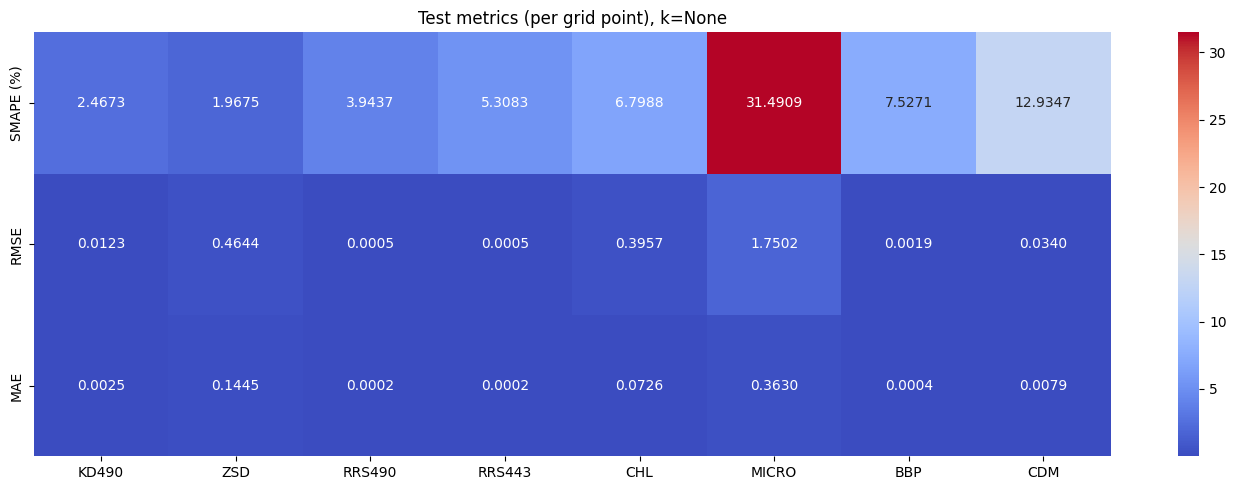

,KD490,ZSD,RRS490,RRS443,CHL,MICRO,BBP,CDM
SMAPE (%),2.467262,1.967481,3.943726,5.308304,6.798844,31.490922,7.527051,12.934678
RMSE,0.012277,0.464444,0.000548,0.000484,0.395702,1.750197,0.001870,0.033958
MAE,0.002538,0.144528,0.000164,0.000195,0.072620,0.363027,0.000401,0.007916


In [ ]:
compute_test_metrics(reconstructed_val, val_set_original, parameter_columns)

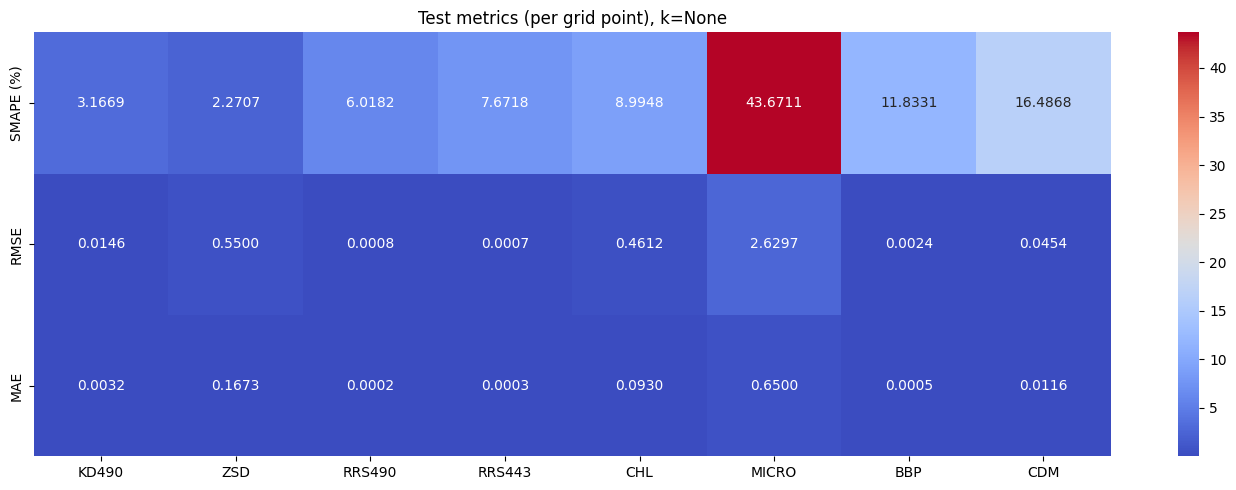

,KD490,ZSD,RRS490,RRS443,CHL,MICRO,BBP,CDM
SMAPE (%),3.166907,2.270748,6.018240,7.671806,8.994797,43.671102,11.833055,16.486831
RMSE,0.014573,0.549959,0.000834,0.000652,0.461237,2.629667,0.002432,0.045376
MAE,0.003204,0.167264,0.000237,0.000256,0.092996,0.649958,0.000540,0.011610


In [ ]:
compute_test_metrics(reconstructed_test, test_set_original, parameter_columns)

## Actual versus Predicted plots: daily average with winter mask

In [ ]:
# Define winter date ranges (as datetime objects)
winter_gaps = [
    (pd.to_datetime("2024-11-15"), pd.to_datetime("2025-01-28")),
    # Add more if needed
]

def mask_winter_gaps(dates, values):
    """Set values to NaN for all dates within winter_gaps."""
    masked = values.copy()
    for start, end in winter_gaps:
        mask = (dates >= start) & (dates <= end)
        masked[mask] = np.nan
    return masked

def plot_spatially_averaged_predictions(val_set, val_predictions, parameter_columns):
    """
    Spatially average predictions and truth across all grid points, then plot
    true-vs-predicted series (validation period only) in a 4x2 subplot.
    Winter gaps are fully blank (no lines shown).
    """
    all_preds, all_truths = [], []

    for (lat, lon), preds in val_predictions.items():
        val_ts = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)]
        val_ts = val_ts.sort_values('date')[parameter_columns].values

        if preds.shape != val_ts.shape:
            continue

        all_preds.append(preds)
        all_truths.append(val_ts)

    if len(all_preds) == 0:
        print("No valid grid points found to average over.")
        return

    all_preds = np.stack(all_preds)
    all_truths = np.stack(all_truths)

    avg_preds = all_preds.mean(axis=0)
    avg_truths = all_truths.mean(axis=0)

    sample_point = next(iter(val_predictions.keys()))
    dates = pd.to_datetime(
        val_set[(val_set['lat_5km'] == sample_point[0]) &
                (val_set['lon_5km'] == sample_point[1])]
        .sort_values('date')['date']
        .values
    )

    fig, axes = plt.subplots(4, 2, figsize=(20, 20))
    axes = axes.flatten()

    for i, param in enumerate(parameter_columns):
        ax = axes[i]

        # Mask winter gaps in the series
        masked_truth = mask_winter_gaps(dates, avg_truths[:, i])
        masked_preds = mask_winter_gaps(dates, avg_preds[:, i])

        ax.plot(dates, masked_truth, label='Actual', color='blue', alpha=0.9)
        ax.plot(dates, masked_preds, label='Predicted', color='red', alpha=0.9, linestyle='--')

        # Shade the winter gaps
        for start, end in winter_gaps:
            ax.axvspan(start, end, color='grey', alpha=0.5, label='Winter Gap' if i == 0 else "")

        ax.set_title(param)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.suptitle("Spatially Averaged True vs Predicted, VAR with 1 lag (Validation)", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


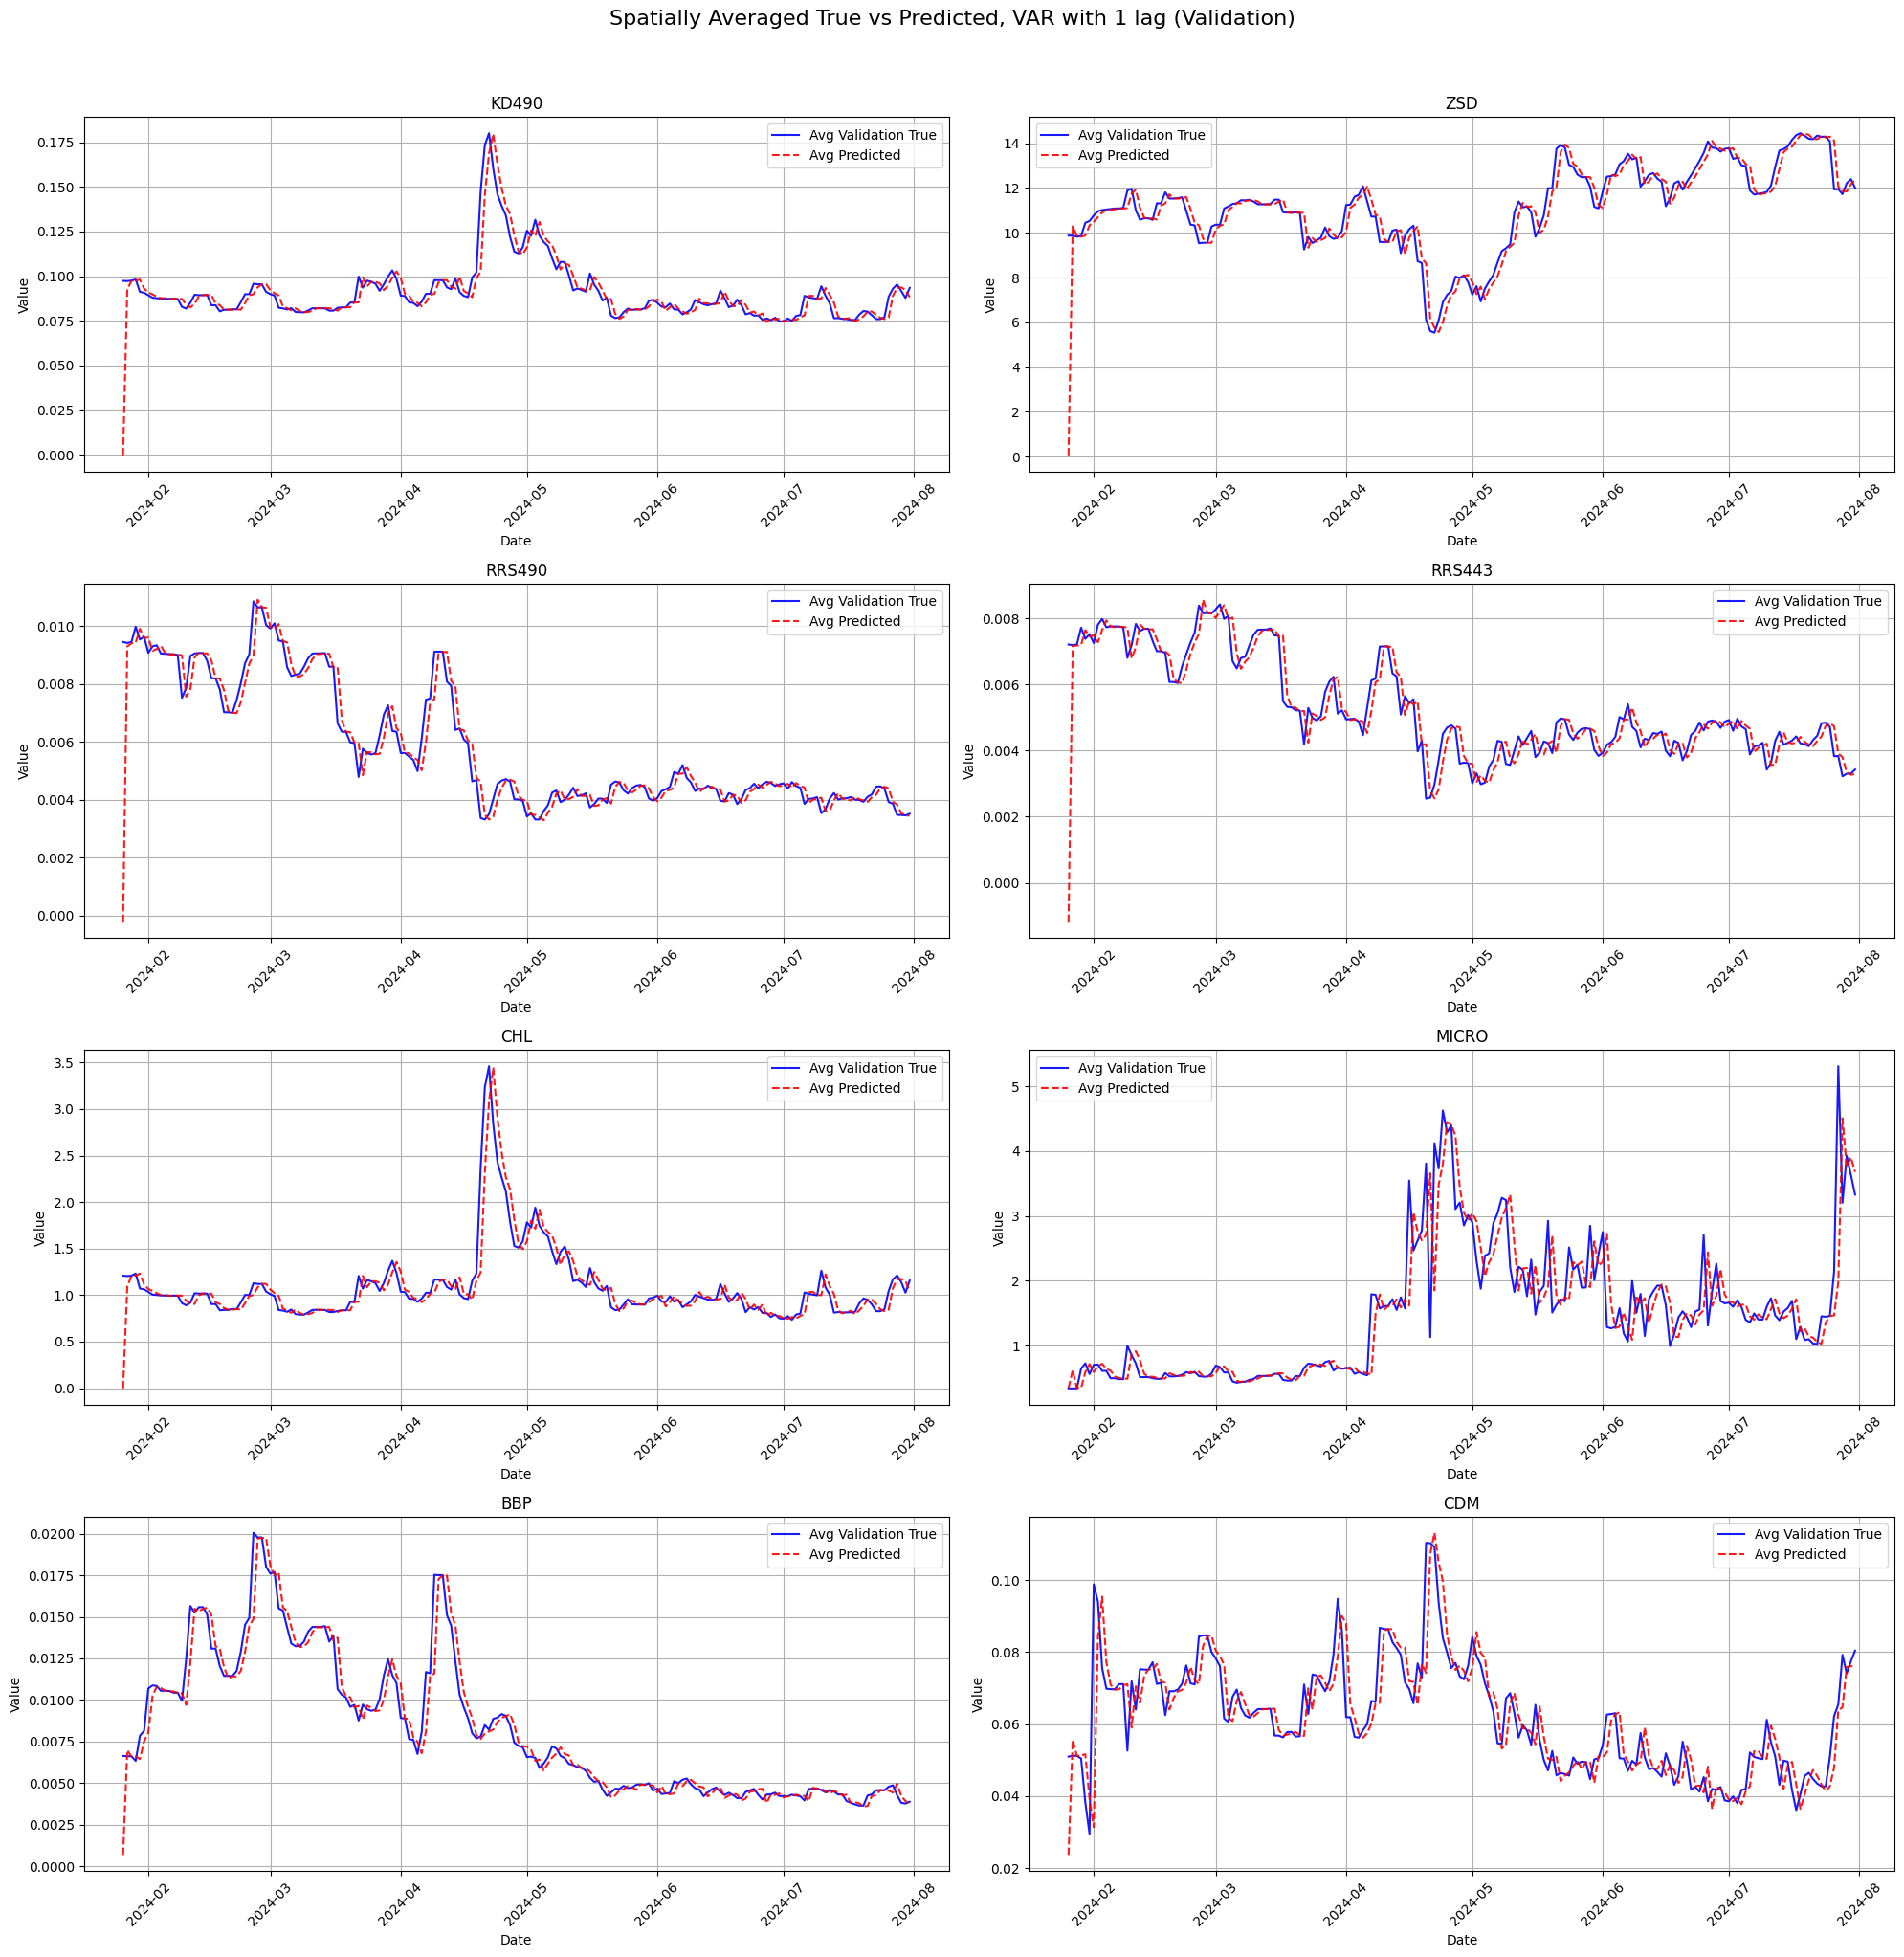

In [ ]:
#### VALIDATION SET PLOT
plot_spatially_averaged_predictions(val_set_original, reconstructed, parameter_columns)

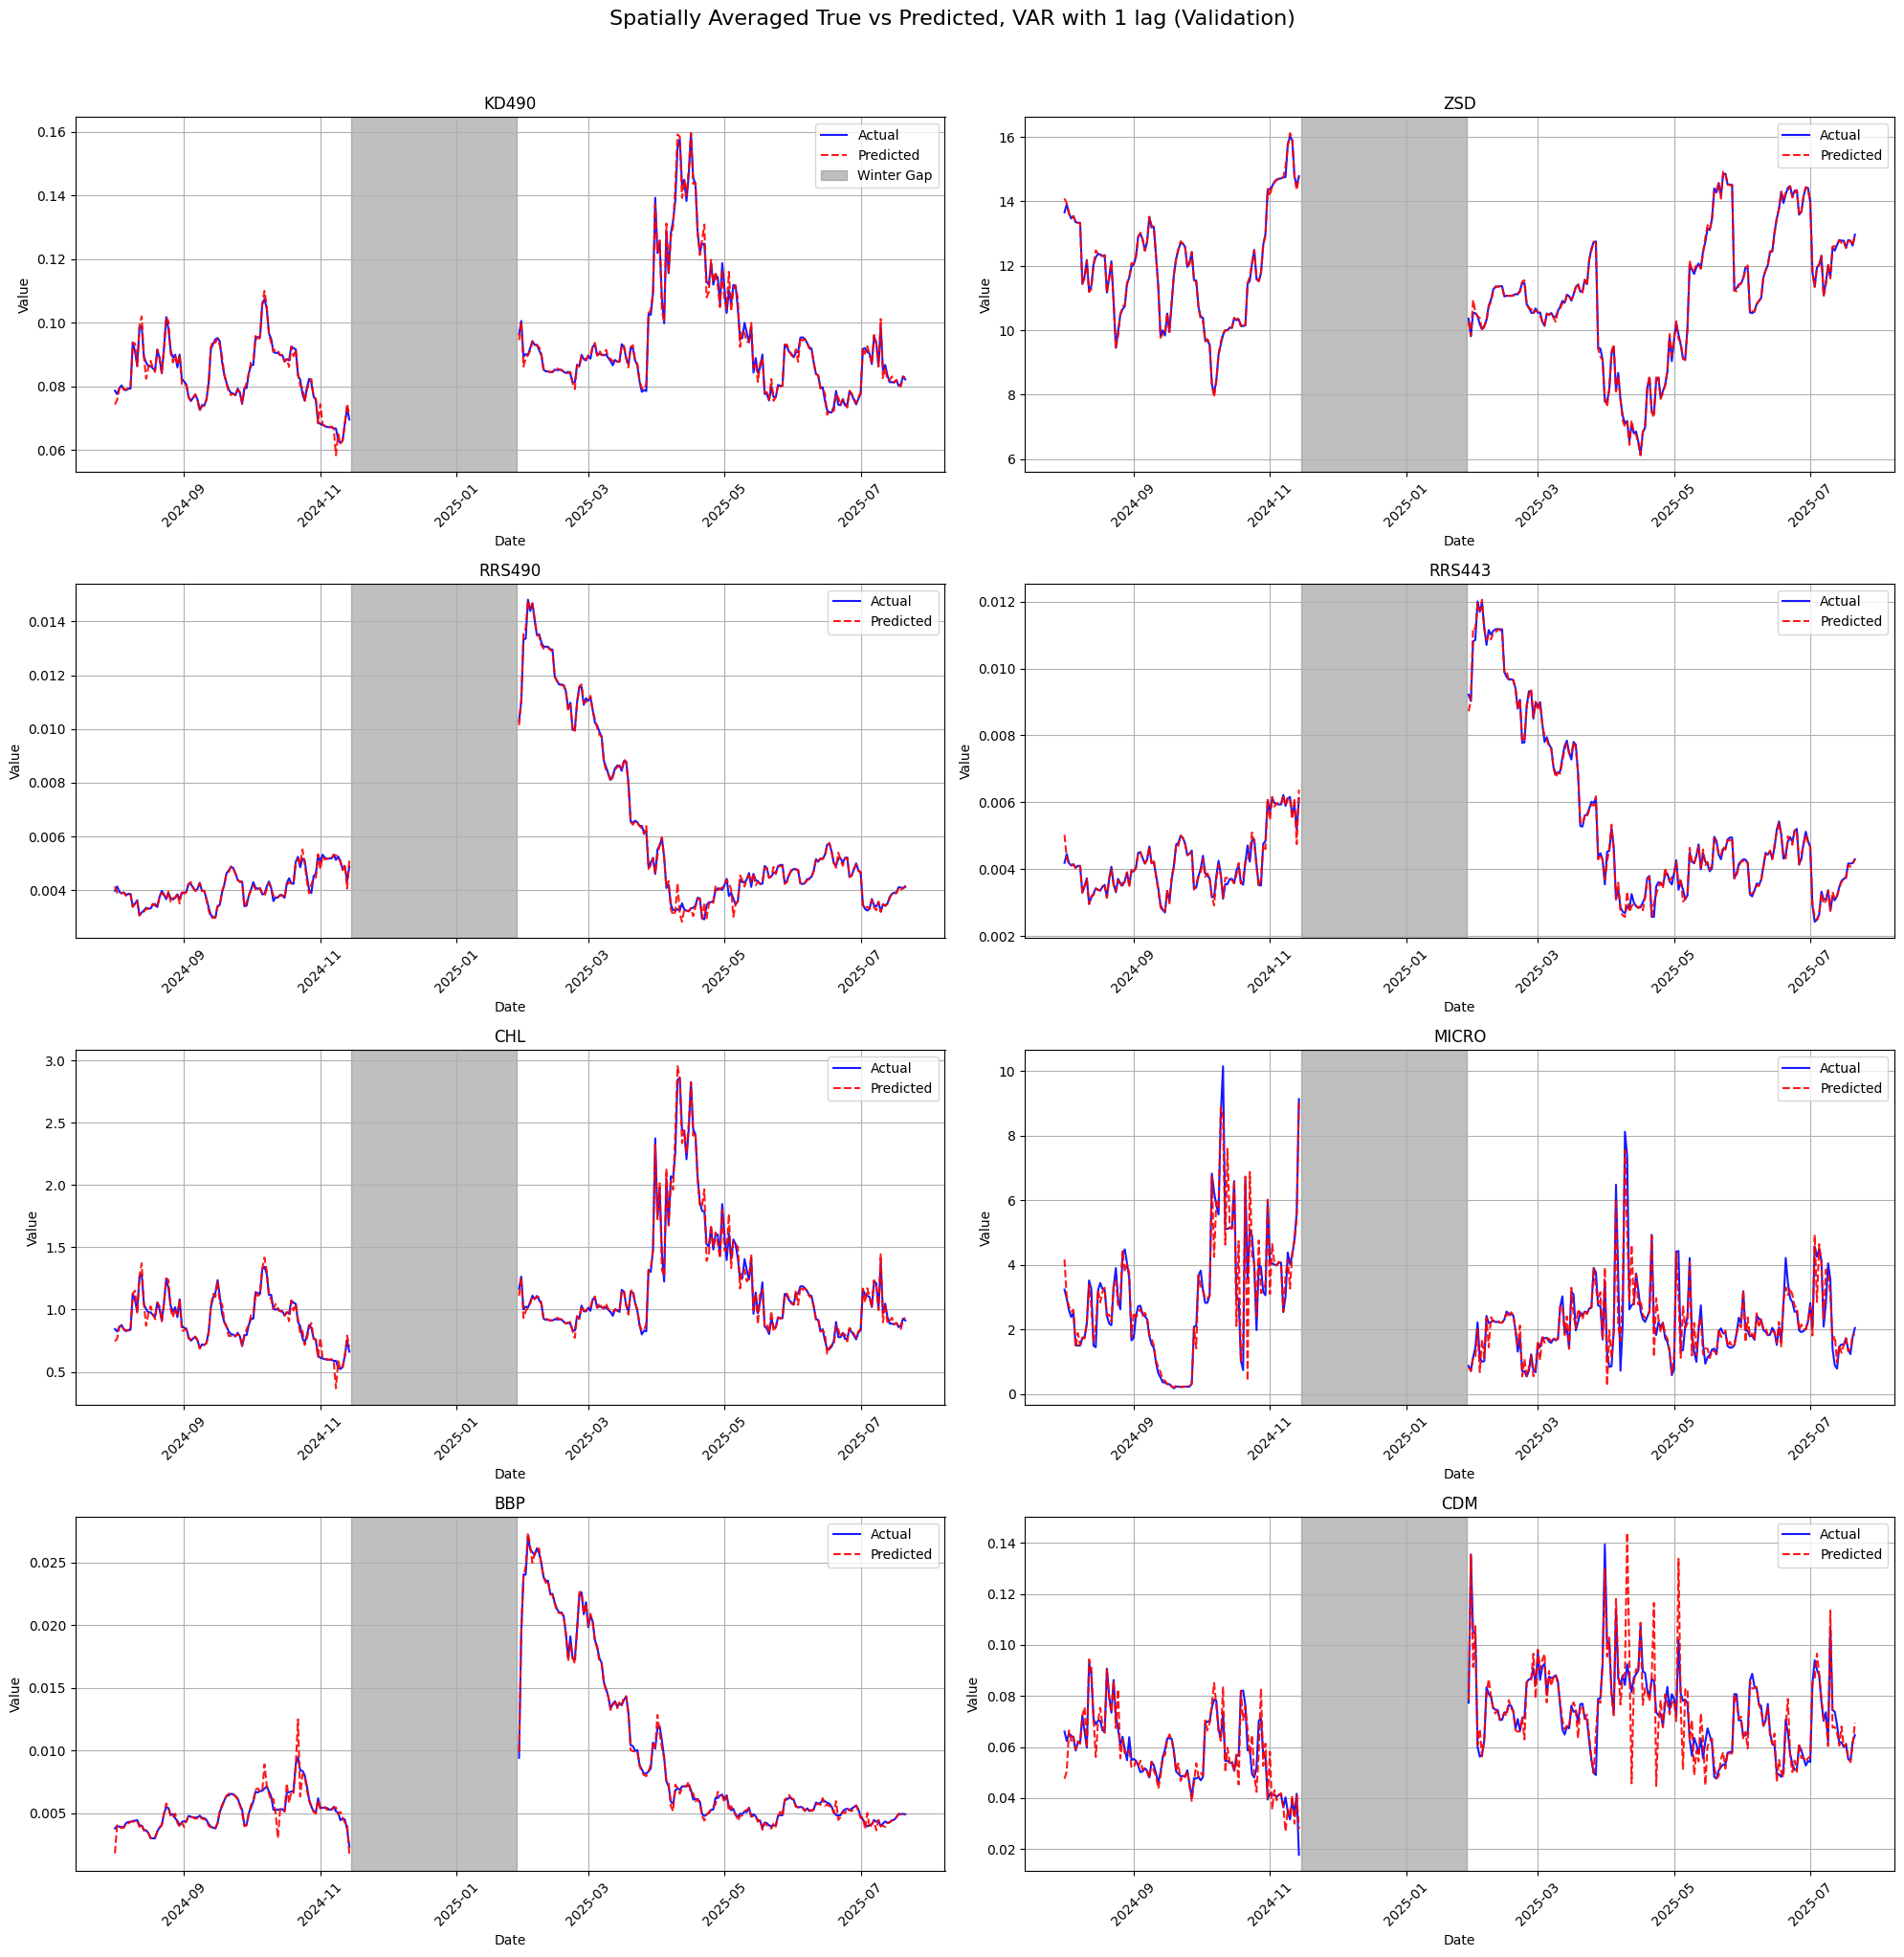

In [ ]:
#### TEST SET PLOT
plot_spatially_averaged_predictions(test_set_original, reconstructed_test, parameter_columns)